In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install facenet_pytorch



     |████████████████████████████████| 1.9MB 28.1MB/s 


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F

import torchvision.utils as vutils
from io import open
import os
from PIL import Image

In [5]:
import numpy as np
import pandas as pd
import os
import glob
import cv2 
from PIL import Image
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from facenet_pytorch import MTCNN,InceptionResnetV1
from matplotlib import pyplot as plt
import time,copy
%matplotlib inline

In [6]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(100,100)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize(size=(100,100)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data_dir = r'/content/drive/MyDrive/bigdatacrop'
image_datasets = { datasets.ImageFolder(os.path.join(data_dir))}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
print(dataset_sizes)
print(dataloaders)
class_names = image_datasets['train'].classes
class_names


{'train': 288, 'val': 79}
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f69ba4c5250>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f69ba45d950>}


['s01',
 's02',
 's03',
 's04',
 's05',
 's06',
 's07',
 's08',
 's09',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's20']

In [9]:
def get_model():
  model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))
  layer_list = list(model_ft.children())[-5:]
  model_ft = nn.Sequential(*list(model_ft.children())[:-5])
  for param in model_ft.parameters():
      param.requires_grad = False
  model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
  model_ft.last_linear = nn.Sequential(
      Flatten(),
      nn.Linear(in_features=1792, out_features=512, bias=False),
      normalize())
  model_ft.logits = nn.Linear(layer_list[3].num_features, len(class_names))

  model_ft.softmax = nn.Softmax(dim=1)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(device)
  model_ft = model_ft.to(device)
  return model_ft

In [12]:
model_ft = get_model()
model_ft.load_state_dict(torch.load(r'/content/drive/MyDrive/cnn.pth0100100'))



cuda:0


<All keys matched successfully>

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.99)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


cuda:0


In [14]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0
    best_train_acc=0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(preds,labels)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() /dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best  train val Acc: {:4f}'.format(best_train_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/99
----------
train Loss: 2.9731 Acc: 0.8611
val Loss: 2.9783 Acc: 0.8101
Epoch 1/99
----------
train Loss: 2.9727 Acc: 0.8403
val Loss: 2.9752 Acc: 0.8734
Epoch 2/99
----------
train Loss: 2.9726 Acc: 0.8646
val Loss: 2.9747 Acc: 0.8481
Epoch 3/99
----------
train Loss: 2.9732 Acc: 0.8438
val Loss: 2.9816 Acc: 0.7595
Epoch 4/99
----------
train Loss: 2.9726 Acc: 0.8646
val Loss: 2.9771 Acc: 0.8481
Epoch 5/99
----------
train Loss: 2.9729 Acc: 0.8576
val Loss: 2.9746 Acc: 0.8734
Epoch 6/99
----------
train Loss: 2.9729 Acc: 0.8507
val Loss: 2.9800 Acc: 0.7722
Epoch 7/99
----------
train Loss: 2.9728 Acc: 0.8542
val Loss: 2.9754 Acc: 0.8354
Epoch 8/99
----------
train Loss: 2.9730 Acc: 0.8646
val Loss: 2.9753 Acc: 0.8734
Epoch 9/99
----------
train Loss: 2.9729 Acc: 0.8438
val Loss: 2.9783 Acc: 0.7848
Epoch 10/99
----------
train Loss: 2.9728 Acc: 0.8681
val Loss: 2.9792 Acc: 0.7595
Epoch 11/99
----------
train Loss: 2.9724 Acc: 0.8681
val Loss: 2.9745 Acc: 0.8734
Epoch 12/99
--

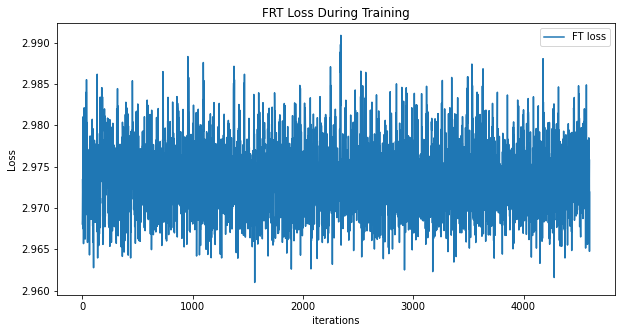

In [15]:

model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [16]:
torch.save(model_ft.state_dict(), "cnn.pth0011")

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model_ft.to(device)

cuda:0


In [18]:
torch.save(model_ft, 'cnn.pth0011')
model=torch.load('cnn.pth0011')
model.eval()

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [19]:
data_transforms =transforms.Compose([
        transforms.Resize(size=(100,100)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [20]:
imagepath = '/content/drive/MyDrive/bigdatacrop/train/s15/07.jpg'
image = Image.open(imagepath)
imgblob = data_transforms(image)
from torch.autograd import Variable
imgblob.unsqueeze_(dim=0)
imgblob = Variable(imgblob)
torch.no_grad()
model_ft.eval()
predict =model_ft(imgblob.cuda())
index = predict.cpu().data.numpy().argmax()
print(index)

14
